# ENSF 511, W2022, Lab 3 - Part 1 (Model Optimization

## Quantization

   #### Joel Aaron Marquez, Edited on April 12
   
   Snippets of code to train the model is adapted from the T.A, Majid, and Tensorflow Model Optimization (link [here](https://www.tensorflow.org/model_optimization/guide)).

##### Loading Libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

import tensorflow_model_optimization as tfmot # Libraries to perform multiple model optimizations

In [3]:
PATH= "C:/Users/User/Downloads/Lab3/MobileNet-samples"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset_init = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset_init = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset_init.class_names

print(class_names)
val_batches = tf.data.experimental.cardinality(validation_dataset_init)
test_dataset = validation_dataset_init.take(val_batches // 5)
validation_dataset = validation_dataset_init.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat', 'cat']
Number of validation batches: 26
Number of test batches: 6


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset_init.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

(32, 7, 7, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()   
print(len(model.trainable_variables)           )  

(32, 1280)
(32, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                          

In [6]:
# Initial Training
initial_epochs = 30
history = model.fit(train_dataset,validation_data=validation_dataset,
                    epochs=initial_epochs)

Epoch 1/30
94/94 [==============================] - 91s 900ms/step - loss: 0.7094 - accuracy: 0.5647 - val_loss: 0.3960 - val_accuracy: 0.8205
Epoch 2/30
94/94 [==============================] - 82s 868ms/step - loss: 0.4321 - accuracy: 0.7960 - val_loss: 0.2586 - val_accuracy: 0.9505
Epoch 3/30
94/94 [==============================] - 82s 868ms/step - loss: 0.2928 - accuracy: 0.9067 - val_loss: 0.1930 - val_accuracy: 0.9765
Epoch 4/30
94/94 [==============================] - 81s 864ms/step - loss: 0.2281 - accuracy: 0.9253 - val_loss: 0.1661 - val_accuracy: 0.9703
Epoch 5/30
94/94 [==============================] - 81s 867ms/step - loss: 0.1817 - accuracy: 0.9503 - val_loss: 0.1432 - val_accuracy: 0.9752
Epoch 6/30
94/94 [==============================] - 80s 857ms/step - loss: 0.1584 - accuracy: 0.9537 - val_loss: 0.1236 - val_accuracy: 0.9765
Epoch 7/30
94/94 [==============================] - 81s 858ms/step - loss: 0.1453 - accuracy: 0.9570 - val_loss: 0.1170 - val_accuracy: 0.9802

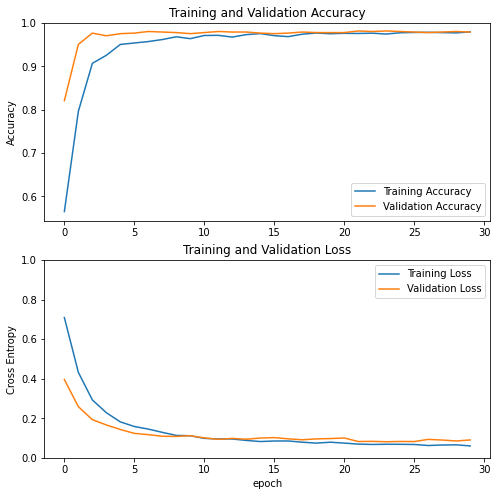

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()   

##### Fine Tuning

In [8]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [10]:
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

2

In [11]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/60
94/94 [==============================] - 85s 865ms/step - loss: 0.0537 - accuracy: 0.9823 - val_loss: 0.0886 - val_accuracy: 0.9765
Epoch 31/60
94/94 [==============================] - 81s 866ms/step - loss: 0.0613 - accuracy: 0.9787 - val_loss: 0.0925 - val_accuracy: 0.9765
Epoch 32/60
94/94 [==============================] - 82s 871ms/step - loss: 0.0638 - accuracy: 0.9777 - val_loss: 0.0841 - val_accuracy: 0.9802
Epoch 33/60
94/94 [==============================] - 82s 872ms/step - loss: 0.0587 - accuracy: 0.9787 - val_loss: 0.0821 - val_accuracy: 0.9790
Epoch 34/60
94/94 [==============================] - 81s 861ms/step - loss: 0.0587 - accuracy: 0.9787 - val_loss: 0.0879 - val_accuracy: 0.9790
Epoch 35/60
94/94 [==============================] - 80s 853ms/step - loss: 0.0578 - accuracy: 0.9797 - val_loss: 0.0854 - val_accuracy: 0.9802
Epoch 36/60
94/94 [==============================] - 80s 848ms/step - loss: 0.0584 - accuracy: 0.9777 - val_loss: 0.0835 - val_accuracy:

##### Evaluating Performance

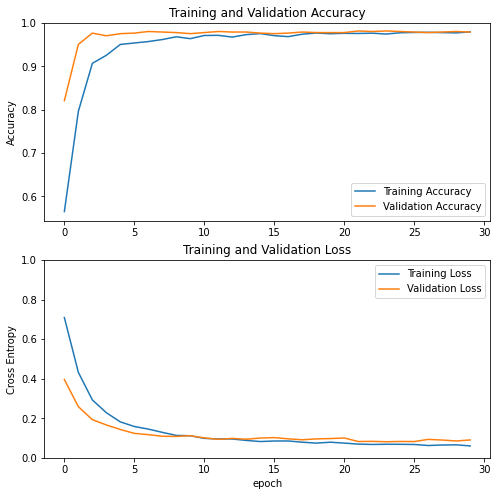

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()   

In [13]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 652ms/step - loss: 0.1073 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


Predictions:
 [0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1]
Labels:
 [0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1]


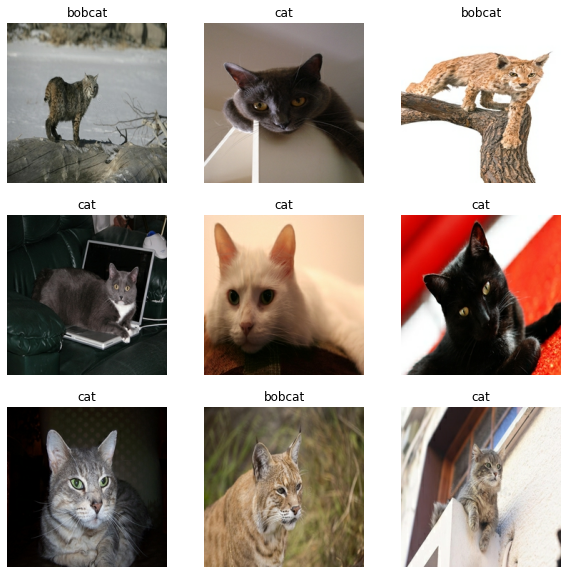

In [14]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

##### Applying quantization

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Quantization starts here
converter.target_spec.supported_types = [tf.float16] # 50% Size Reduction
tflite_model = converter.convert()

with open('model(quantized).tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfrx2e324\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfrx2e324\assets
